In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
import spacy

In [2]:
%%time
data = pd.read_csv('proc_17_108_unique_comments_text_dupe_count.csv')
print(f"Loaded in {len(data)} entries aggregating {data['dupe_count'].sum()} total comments.")

Loaded in 2955186 entries aggregating 22078910.0 total comments.
CPU times: user 20.2 s, sys: 864 ms, total: 21 s
Wall time: 21 s


In [3]:
nlp = spacy.load("en", tagger=False, entity=False, matcher=False, parser=False)

In [4]:
#take a sample to vectorize and cluster with dbscan
sample_size = 10000 # can play with this - starts to get unmanageable on my desktop @ sample_size > 100000
data_sample = data.sample(sample_size)

In [5]:
def encode_doc_vecs(docs):
    #encode mean word vector per document - might take a while
    #it took about 10s per 10,000 documents on my desktop
    #would want to parallelize this for a large enough job
    doc_vecs = []
    for doc in docs:
        #encode the doc if it is a string
        if type(doc) == str:
            doc_spaced = nlp(doc)
            doc_vec = np.mean([word.vector for word in doc_spaced], axis=0)
            #in case the doc vector could not be encoded, e.g., empty string, no words found
            if type(doc_vec) != np.ndarray or doc_vec.shape[0] != 300:
                print(f"Not Vectorizable: {doc}")
                doc_vec = np.zeros(300)
        else:
            print(f"Not a String: {doc}")
            doc_vec = np.zeros(300)
        doc_vecs.append(doc_vec)
    return doc_vecs

In [6]:
%%time
doc_vecs = encode_doc_vecs(data_sample['text_data'])

CPU times: user 8.66 s, sys: 0 ns, total: 8.66 s
Wall time: 8.67 s


In [7]:
# play with eps and metric
# higher eps will take *much* more time & resources
clusterer = DBSCAN(eps=0.001, min_samples=5, n_jobs=-1, metric='cosine')

In [8]:
# can also try HAC - play with number of clusters, ward linkage seemed to give the best results generally
clusterer = AgglomerativeClustering(n_clusters=40, linkage='ward')

In [9]:
%%time
labels = clusterer.fit_predict(doc_vecs)

CPU times: user 20.8 s, sys: 188 ms, total: 21 s
Wall time: 21 s


In [10]:
X_clustered = pd.concat([pd.Series(data=labels, name='cluster'),data_sample.reset_index(drop=True),pd.DataFrame(doc_vecs)], axis=1)
# take a quick peek
X_clustered.sample(50)

,cluster,docid,text_data,dupe_count,0,1,2,3,4,5,...,290,291,292,293,294,295,296,297,298,299
2617,33,3969357,"Dear Chairman Pai, I am a voter worried about...",2.0,-0.015157,0.112703,-0.122902,-0.037582,0.000803,0.050359,...,-0.135979,0.055029,-0.004320,-0.031622,0.057389,-0.019021,-0.002124,-0.087668,0.021567,0.136336
3134,22,7855836,The FCC's Open Internet Rules (net neutrality ...,1.0,-0.043061,0.162156,-0.156683,-0.064222,0.061563,-0.016131,...,-0.239542,0.001498,0.005741,-0.034514,0.012218,-0.020385,-0.001659,-0.083057,0.063025,0.101893
6561,27,9872007,I am in favor of strong net neutrality under T...,129.0,-0.057064,0.109653,-0.101222,-0.027983,0.001436,0.100275,...,-0.070016,0.051660,-0.034462,-0.179260,-0.001981,0.053158,0.036034,-0.104171,-0.020185,0.009787
1411,26,1152239,"As an Internet user, I'm asking the FCC to pro...",1.0,-0.034140,0.117758,-0.170461,-0.069788,0.048333,0.035073,...,-0.241686,0.010709,0.028442,-0.010912,0.026025,-0.001645,-0.021549,-0.102870,0.016002,0.147391
8771,5,242073,Preserve net neutrality and Title 2 and for he...,1.0,-0.179776,-0.009612,-0.197282,0.023762,0.034976,-0.062394,...,-0.128931,-0.111596,-0.023754,-0.073613,-0.007443,-0.042823,-0.035309,-0.161446,0.007839,0.044988
1461,29,12755236,The FCC's Open Internet Rules (net neutrality ...,9.0,-0.040180,0.158023,-0.160700,-0.044328,0.062115,-0.018222,...,-0.251985,0.006493,0.016967,-0.034678,0.009131,-0.021973,-0.008985,-0.088231,0.076560,0.099095
7669,29,10931447,The FCC's Open Internet Rules (net neutrality ...,1.0,-0.040216,0.158008,-0.161275,-0.044192,0.062521,-0.018013,...,-0.251816,0.006408,0.017050,-0.034757,0.009035,-0.021469,-0.009682,-0.087811,0.076137,0.098491
1569,29,10238992,The FCC's Open Internet Rules (net neutrality ...,1.0,-0.040180,0.158023,-0.160700,-0.044328,0.062115,-0.018222,...,-0.251985,0.006493,0.016967,-0.034678,0.009131,-0.021973,-0.008985,-0.088231,0.076560,0.099095
9288,22,7789741,The FCC's Open Internet Rules (net neutrality ...,1.0,-0.043077,0.161410,-0.158212,-0.063387,0.060898,-0.016799,...,-0.239999,0.001308,0.006739,-0.033413,0.012226,-0.021608,-0.003177,-0.083220,0.063265,0.102240
9294,5,310436,Writing to advocate for keeping net neutrality...,1.0,-0.138802,0.069890,-0.184214,0.003004,0.028289,-0.006705,...,-0.117600,-0.087390,0.006461,-0.053191,0.012083,-0.077973,0.031150,-0.200529,-0.051909,0.037674


In [11]:
# visualize silhouette scores (without outliers)
# our goal is to find the largest, densest clusters from which to manually pick out signature strings
from sklearn.metrics import silhouette_samples, silhouette_score

In [12]:
# we can focus on certain clusters using a mask, but it's not useful to plot the -1 outliers
# w/ caveat that changing the mask will artifically inflate your sil score
num_clusters_skipped = 0 # speed up by skipping the first few (huge) clusters; 
mask = list(range(num_clusters_skipped, X_clustered['cluster'].max() + 1)) #since count = max + 1; ignore outliers (-1)

In [13]:
X_masked = X_clustered[X_clustered['cluster'].isin(mask)]
features = X_masked.iloc[:,-300:]
cluster_labels = X_masked['cluster']

In [14]:
# Calculate silhouette scores - takes a while for if you don't mask out first few clusters
n_clusters = len(mask)

# Summary stat
silhouette_avg = silhouette_score(features, cluster_labels)
print(f"For the clusters examined, the average silhouette_score is {silhouette_avg}")

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(features, cluster_labels)

For the clusters examined, the average silhouette_score is 0.22298237036108595


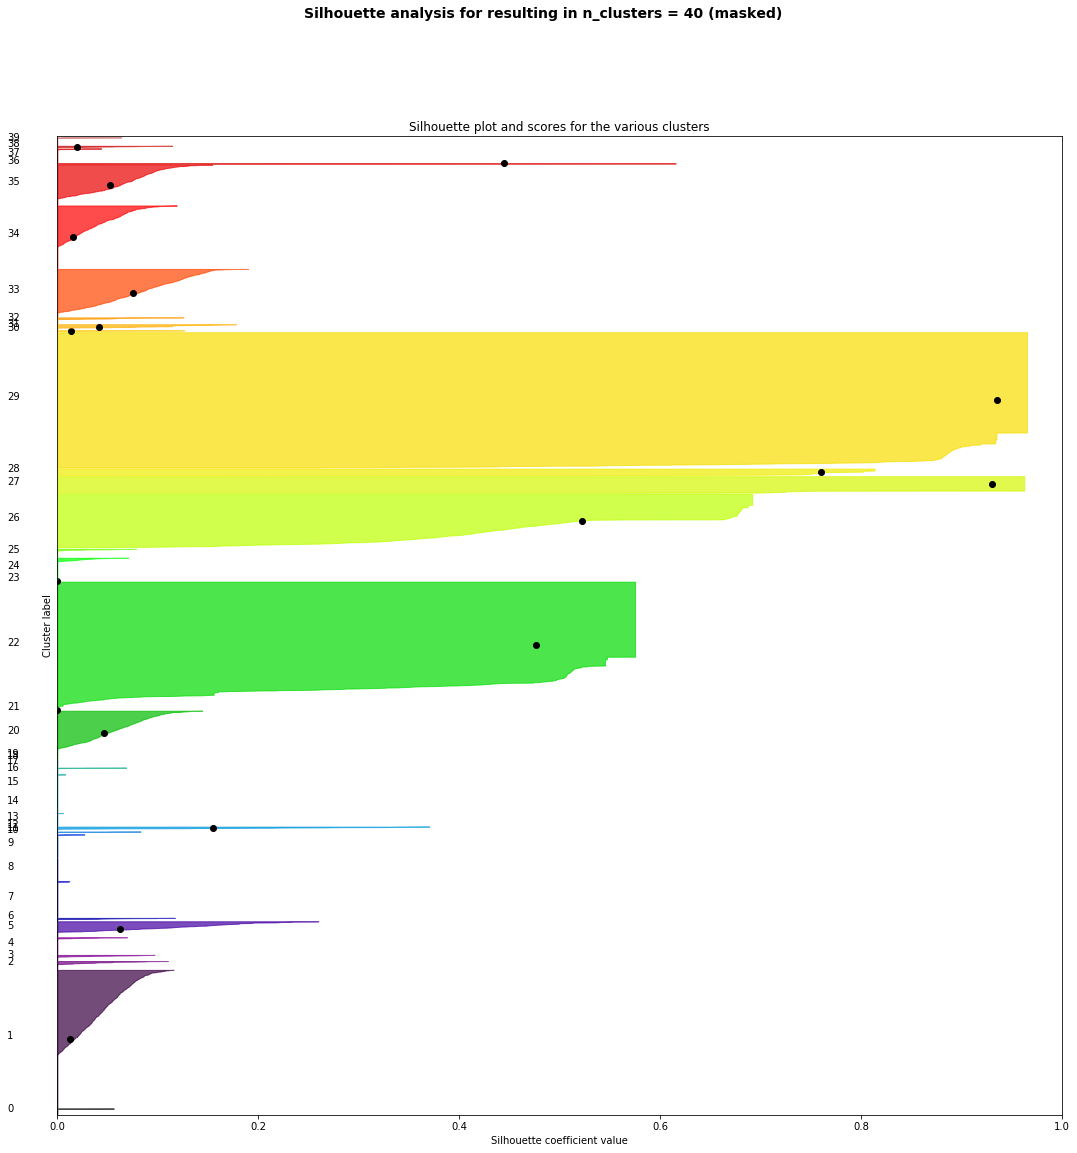

In [15]:
# Plot to get a sense of density and separation of the formed clusters
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Save the scores
X_masked['silhouette_score'] = sample_silhouette_values

fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 18)

# xlim -> silhouette coefficient range (unlikely negative in our case)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0, len(X_masked) + (n_clusters + 1) * 10])

y_lower = 10
for i in mask:
    # Aggregate and sort to get a profile for cluster i
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    # Draw
    color = cm.spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # A dab at the average silhouette score for cluster i
    ax1.scatter(x=ith_cluster_silhouette_values.mean(), y=y_lower + 0.5 * size_cluster_i, color='k')
    
    # Compute the new y_lower for next cluster
    y_lower = y_upper + 10
    
ax1.set_title("Silhouette plot and scores for the various clusters")
ax1.set_xlabel("Silhouette coefficient value")
ax1.set_ylabel("Cluster label")
ax1.set_yticks([])  # clear
ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

plt.suptitle(f"Silhouette analysis for resulting in n_clusters = {n_clusters} (masked)",
             fontsize=14, fontweight='bold')

plt.show()

In [18]:
pd.options.display.max_colwidth = 500
cluster_num = 33 #pick your cluster - the triangular ones are the mad-libs
cluster_to_check = X_masked[X_masked['cluster'] == cluster_num][['silhouette_score','text_data']].sort_values('silhouette_score')

In [19]:
# poke around to make sure it looks reasonable and we can pick out a signature string from it

#cluster_to_check.head(10)
cluster_to_check.tail(10)
#cluster_to_check.sample(50)

,silhouette_score,text_data
5164,0.155933,"To the Federal Communications Commission: My comments re: Title 2 and net neutrality. I implore the government to reverse The previous administration's policy to control Internet access. Individual citizens, as opposed to the FCC Enforcement Bureau, ought to purchase whichever services they choose. The previous administration's policy to control Internet access is a corruption of the open Internet. It undid a hands-off approach that worked very well for a long time with nearly universal app..."
5162,0.156461,"Dear Chairman Pai, In reference to network neutrality regulations. I strongly encourage the FCC to reverse The previous administration's plan to control the web. Internet users, as opposed to the FCC, ought to purchase which products they prefer. The previous administration's plan to control the web is a distortion of net neutrality. It undid a hands-off system that worked supremely smoothly for two decades with both parties' approval."
1144,0.157958,"I'd like to share my thoughts on the FCC's Open Internet order. I demand the Federal Communications Commission to rescind The previous administration's decision to regulate the Internet. Individuals, as opposed to the FCC Enforcement Bureau, should be empowered to select which services we choose. The previous administration's decision to regulate the Internet is a distortion of net neutrality. It ended a hands-off policy that functioned supremely successfully for two decades with Republican ..."
9670,0.160363,"Mr Pai: With respect to Network Neutrality. I advocate the government to rescind The previous administration's policy to control the web. Individual citizens, rather than Washington, should purchase the applications we want. The previous administration's policy to control the web is a distortion of the open Internet. It undid a market-based system that functioned very, very well for two decades with broad bipartisan support."
2845,0.163389,"FCC: I have concerns about network neutrality regulations. I would like to urge the commission to reverse The previous administration's policy to control the web. Citizens, not Washington, should be able to enjoy which services they desire. The previous administration's policy to control the web is a corruption of net neutrality. It ended a hands-off framework that functioned exceptionally successfully for many years with nearly universal approval."
4607,0.164459,"I'm contacting you about net neutrality regulations. I would like to urge the government to rescind The previous administration's decision to control the web. Internet users, rather than big government, should be able to select the services they desire. The previous administration's decision to control the web is a exploitation of net neutrality. It undid a market-based system that performed exceptionally successfully for two decades with Republican and Democrat support."
8241,0.166257,"Dear Commissioners: I have concerns about the FCC's Open Internet order. I strongly request Ajit Pai to rescind The previous administration's decision to control the web. Individuals, as opposed to the FCC Enforcement Bureau, should be empowered to use which services they choose. The previous administration's decision to control the web is a corruption of the open Internet. It broke a pro-consumer framework that performed very well for two decades with broad bipartisan support."
4440,0.172154,"FCC: With respect to net neutrality rules. I ask the government to reverse The previous administration's scheme to regulate the web. Citizens, rather than the FCC Enforcement Bureau, should be able to purchase whichever services we choose. The previous administration's scheme to regulate the web is a betrayal of the open Internet. It ended a hands-off policy that performed very successfully for two decades with both parties' backing."
1266,0.175087,"To the Federal Communications Commission: In the matter of Title II rules. I strongly request you to rescind Th